In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os 
from datetime import datetime
import seaborn as sn
import pandas as pd

# show all the output 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Step1: Define Help Functions:

### 1. Help Fucntions for Downloading and Importing Data

In [2]:
import numpy as np
import pickle
import os
import urllib.request
import tarfile
import zipfile

########################################################################

# Set directory to save the data-set.
data_path = "data/CIFAR-10/"

# URL for the data-set
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

########################################################################

# Width and height of each image.
img_size = 32

# Number of channels in each image
num_channels = 3

# Length of the flattened image array
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = 10

########################################################################

# Number of batch-files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
_num_images_train = _num_files_train * _images_per_file

########################################################################


def _get_file_path(filename=""):

# Return the full path of a data-file for the data-set.


    return os.path.join(data_path, "cifar-10-batches-py/", filename)


def _unpickle(filename):

    # Unpickle the given file and return the data.
    
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        data = pickle.load(file, encoding='bytes')

    return data

def ZCAtrans(raw):
    
    # ZCA whittening function
    xm = np.mean(raw, axis = 0)
    raw= raw- xm
    raw2 = raw.reshape((raw.shape[0], -1))
    
    # raw is assumed to be zero-mean
    C = np.dot( raw2.T, raw2 )/raw2.shape[0]
    
    U, eva, V = np.linalg.svd(C)
    sqeva = np.sqrt(eva + 0.001)
    Uzca = np.dot(U/sqeva[np.newaxis, :], U.T)
    X = np.dot(raw2, Uzca)
    return X

def _convert_images(raw):
    
    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0
    # Performance ZCA whittening on the raw images
    raw_float = ZCAtrans(raw_float)

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])
    
    # normailze each image
    for i in range(images.shape[0]):
        m,M = images[i].min(), images[i].max()
        images[i]=(images[i] - m) / (M - m)

    return images


def _load_data(filename):

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls


########################################################################

def maybe_download_and_extract(url, download_dir):

    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,filename=file_path)
                                                  

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")



def load_class_names():

    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names

def one_hot_encoded(class_numbers, num_classes=None):

    # Find the number of classes if None is provided.
    # Assumes the lowest class-number is zero.
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1

    return np.eye(num_classes, dtype=float)[class_numbers]

def load_training_data():

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


def load_test_data():
    
    images, cls = _load_data(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)

########################################################################
## The following is for loading testing data to show the original images
#######################################################################

def _convert_images_for_print(raw):

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data_for_print(filename):

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images_for_print(raw_images)

    return images, cls

def load_test_data_for_print():

    images, cls = _load_data_for_print(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


### 2. Help Fucntions for Data Augmentation

In [3]:
## The function is for data augmentation:
########################################################################
def data_augmentation_image(image, training):
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # Randomly cropthe test images
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)
    return image

##########################################################
## The function is for apply data augmentation for all images:
##########################################################
def data_augmentation(images, training):
    images = tf.map_fn(lambda image: data_augmentation_image(image, training), images)
    return images

### 3. Help Function for Bulding CNN

In [4]:
#######################################################
# The function is for compute the cross entropy
#######################################################
def compute_cross_entropy(logits, y):
    sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
    cross_ent = tf.reduce_mean(sm_ce, name='cross_ent')
    return cross_ent


#######################################################
# The function is for compute the cross entropy
#######################################################
def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return  prediction, accuracy

#######################################################
# The function is for geting random batch for training the network
#######################################################
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)
    
    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx,:,:,:]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

######################################################
# The Function for defineing the CNN Network
######################################################
# Inference

def _variable_with_weight_decay(name, shape, stddev, wd):
    """
    Helper to create an initialized Variable with weight decay

    Args:
        name: name of the variable
        shape: list of ints
        stddev: standard deviation of a truncated Gaussian
        wd: add L2Loss weight decay multiplied by this float. If None, weight
            decay is not added for this Variable.

    Returns:
        Variable Tensor
    """
    var = _variable_on_cpu(
        name,
        shape,
        tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var


def _variable_on_cpu(name, shape, initializer):
    """
    Helper to create a Variable stored on CPU memory

    Args:
        name: name of the variable
        shape: list of ints
        initializer: initializer for Variable

    Returns:
        Variable Tensor

    """
    with tf.device('/cpu:0'):
        var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    return var

def compute_logits_cnn(x):
    
    phase_train = tf.placeholder(tf.bool, name='phase_train')

    x = tf.reshape(x, [-1, img_size_cropped, img_size_cropped, 3])

    # layer_conv1
    with tf.variable_scope('conv1') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 3, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name=scope.name)

    # batch normalize
    batch_mean, batch_var = tf.nn.moments(conv1, [0])
    scale = tf.Variable(tf.ones([64]))
    beta = tf.Variable(tf.zeros([64]))
    bn1 = tf.nn.batch_normalization(conv1, batch_mean, batch_var,
                                    beta, scale, 1e-3)
    # max_pool
    pool1 = tf.nn.max_pool(bn1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')

    # layer_conv2
    with tf.variable_scope('conv2') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 64, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name=scope.name)

    # batch normalize
    batch_mean, batch_var = tf.nn.moments(conv2, [0])
    scale = tf.Variable(tf.ones([64]))
    beta = tf.Variable(tf.zeros([64]))
    bn2 = tf.nn.batch_normalization(conv2, batch_mean, batch_var,
                                    beta, scale, 1e-3)

    # max_pool
    pool2 = tf.nn.max_pool(bn2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')
    
    # layer_fc1
    with tf.variable_scope('fc1') as scope:
        # flatten
        reshape = tf.reshape(pool2, [-1, 6*6*64])
        dim = reshape.get_shape()[1].value
        weights = _variable_with_weight_decay('weights', shape=[dim, 256],
                                              stddev=0.04, wd=0.0)
        biases = _variable_on_cpu('biases', [256], tf.constant_initializer(0.0))
        fc1 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)

    # layer_fc2
    with tf.variable_scope('fc2') as scope:
        weights = _variable_with_weight_decay('weights', shape=[256, 128],
                                              stddev=0.04, wd=0.0)
        biases = _variable_on_cpu('biases', [128], tf.constant_initializer(0.0))
        fc2 = tf.nn.relu(tf.matmul(fc1, weights) + biases, name=scope.name)

    # softmax_classifier
    with tf.variable_scope('softmax_linear') as scope:
        weights = _variable_with_weight_decay('weights', [128, num_classes],
                                          stddev=1/128.0, wd=0.0)
        biases = _variable_on_cpu('biases', [num_classes],
                              tf.constant_initializer(0.0))
        softmax_linear = tf.add(tf.matmul(fc2, weights), biases, name=scope.name)   

    return softmax_linear,pool1,pool2

### 4. Help Function for Building Network in Network

In [5]:
#######################################################
# The funciton is for building Network in Network.
#######################################################
def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with kernel size 3, stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

def avgpool(x, k = 3, s = 2, p = 'SAME'):
    """simple wrapper for tf.nn.max_pool with kernel size 3, stride size 2"""
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding= p)

def dropout(x):
    """simple wrapper for tf.nn.dropout with dropout ratio 0.5"""
    return tf.nn.dropout(x, 0.5)

## Define the Network
def compute_logits_NIN(x):
    x_image = tf.reshape(x, [-1, img_size_cropped, img_size_cropped, 3])
    # conv1 / relu1
    W_conv1 = tf.get_variable('W_conv1', shape = [5, 5, 3, 96])
    b_conv1 = tf.get_variable('b_conv1', shape = [96],)
    h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
    
    # cccp1 / relu_cccp1
    W_cccp1 = tf.get_variable('W_cccp1', shape = [1, 1, 96, 80])
    b_cccp1 = tf.get_variable('b_cccp1', shape = [80])
    h_cccp1 = tf.nn.relu(tf.add(conv(h_conv1, W_cccp1), b_cccp1))
    
    # cccp2 / relu_cccp2
    W_cccp2 = tf.get_variable('W_cccp2', shape = [1, 1, 80, 48])
    b_cccp2 = tf.get_variable('b_cccp2', shape = [48])
    h_cccp2 = tf.nn.relu(tf.add(conv(h_cccp1, W_cccp2), b_cccp2))
    
    #print(h_cccp2)
    h_pool1 = maxpool(h_cccp2)
    # drop3
    h_drop3 = dropout(h_pool1)
    # conv2 / relu2
    W_conv2 = tf.get_variable('W_conv2', shape = [5, 5, 48, 96])
    b_conv2 = tf.get_variable('b_conv2',shape = [96])
    h_conv2 = tf.nn.relu(tf.add(conv(h_drop3, W_conv2), b_conv2))
    
    # cccp3 / relu_cccp3
    W_cccp3 = tf.get_variable('W_cccp3', shape = [1, 1, 96, 96])
    b_cccp3 = tf.get_variable('b_cccp3', shape = [96])
    h_cccp3 = tf.nn.relu(tf.add(conv(h_conv2, W_cccp3), b_cccp3))
    
    # cccp4 / relu_cccp4
    W_cccp4 = tf.get_variable('W_cccp4', shape = [1, 1, 96, 96])
    b_cccp4 = tf.get_variable('b_cccp4',shape = [96])
    h_cccp4 = tf.nn.relu(tf.add(conv(h_cccp3, W_cccp4), b_cccp4))
    # poo2
    h_pool2 = avgpool(h_cccp4)
    # drop6
    h_drop6 = dropout(h_pool2)
    
    # conv3 / relu3
    W_conv3 = tf.get_variable('W_conv3', shape = [3, 3, 96, 96])
    b_conv3 = tf.get_variable('b_conv3',shape = [96],)
    h_conv3 = tf.nn.relu(tf.add(conv(h_drop6, W_conv3), b_conv3))
    
    # cccp5 / relu_cccp5
    W_cccp5 = tf.get_variable('W_cccp5', shape = [1, 1, 96, 96])
    b_cccp5 = tf.get_variable('b_cccp5', shape = [96])
    h_cccp5 = tf.nn.relu(tf.add(conv(h_conv3, W_cccp5), b_cccp5))
    
    # cccp6 / relu_cccp6
    W_cccp6 = tf.get_variable('W_cccp6', shape = [1, 1, 96, 10])
    b_cccp6 = tf.get_variable('b_cccp6',shape = [10])
    h_cccp6 = tf.nn.relu(tf.nn.bias_add(conv(h_cccp5, W_cccp6), b_cccp6))
    
    # pool3
    h_pool3 = avgpool(h_cccp6, 6, 1, 'VALID')
    output_reshaped = tf.reshape(h_pool3, [-1,10])

    return output_reshaped,h_conv1,h_cccp1,h_cccp2,h_pool1,h_conv2,h_pool2,h_cccp3,h_cccp4,h_conv3,h_cccp5,h_cccp6,h_pool3

###########################################################
#############################################################

In [5]:
#######################################################
# Network in Network with batch normalization
#######################################################
def compute_logits_NIN_with_BN(x):
    x_image = tf.reshape(x, [-1, img_size_cropped, img_size_cropped, 3])
    # conv1/relu1
    with tf.variable_scope('conv1') as scope:
        kernel = _variable_with_weight_decay('weights',
                                            shape = [5, 5, 3, 96],
                                            stddev = 5e-2,
                                            wd = 0.0)
        conv = tf.nn.conv2d(x_image, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [96], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        # batch normalize
        batch_mean, batch_var = tf.nn.moments(pre_activation, [0])
        scale = tf.Variable(tf.ones([96]))
        beta = tf.Variable(tf.zeros([96]))
        pre_activation = tf.nn.batch_normalization(pre_activation, batch_mean, batch_var,
                                        beta, scale, 1e-3)
        conv1 = tf.nn.relu(pre_activation, name=scope.name)


    # cccp1/relu_cccp1
    with tf.variable_scope('cccp1') as scope:
        kernel = _variable_with_weight_decay('weights',
                                            shape = [1, 1, 96, 80],
                                            stddev = 5e-2,
                                            wd = 0.0)
        conv = tf.nn.conv2d(conv1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [80], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        batch_mean, batch_var = tf.nn.moments(pre_activation, [0])
        scale = tf.Variable(tf.ones([80]))
        beta = tf.Variable(tf.zeros([80]))
        pre_activation = tf.nn.batch_normalization(pre_activation, batch_mean, batch_var,
                                        beta, scale, 1e-3)
        cccp1 = tf.nn.relu(pre_activation, name=scope.name)

    # cccp2/relu_cccp2
    with tf.variable_scope('cccp2') as scope:
        kernel = _variable_with_weight_decay('weights',
                                            shape = [1, 1, 80, 48],
                                            stddev = 5e-2,
                                            wd = 0.0)
        conv = tf.nn.conv2d(cccp1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [48], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        batch_mean, batch_var = tf.nn.moments(pre_activation, [0])
        scale = tf.Variable(tf.ones([48]))
        beta = tf.Variable(tf.zeros([48]))
        pre_activation = tf.nn.batch_normalization(pre_activation, batch_mean, batch_var,
                                        beta, scale, 1e-3)
        cccp2 = tf.nn.relu(pre_activation, name=scope.name)

    # poo1/drop3
    pool1 = tf.nn.max_pool(cccp2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME', name='pool1')
    pool1 = tf.nn.dropout(pool1, 0.5)

    # conv2/relu2
    with tf.variable_scope('conv2') as scope:
        kernel = _variable_with_weight_decay('weights',
                                            shape = [5, 5, 48, 96], 
                                            stddev = 5e-2,
                                            wd = 0.0)
        conv = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [96], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        batch_mean, batch_var = tf.nn.moments(pre_activation, [0])
        scale = tf.Variable(tf.ones([96]))
        beta = tf.Variable(tf.zeros([96]))
        pre_activation = tf.nn.batch_normalization(pre_activation, batch_mean, batch_var,
                                        beta, scale, 1e-3)
        conv2 = tf.nn.relu(pre_activation, name=scope.name)

    # cccp3/relu_cccp3
    with tf.variable_scope('cccp3') as scope:
        kernel = _variable_with_weight_decay('weights',
                                            shape = [1, 1, 96, 96],
                                            stddev = 5e-2,
                                            wd = 0.0)
        conv = tf.nn.conv2d(conv2, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [96], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        batch_mean, batch_var = tf.nn.moments(pre_activation, [0])
        scale = tf.Variable(tf.ones([96]))
        beta = tf.Variable(tf.zeros([96]))
        pre_activation = tf.nn.batch_normalization(pre_activation, batch_mean, batch_var,
                                        beta, scale, 1e-3)
        cccp3 = tf.nn.relu(pre_activation, name=scope.name)

    # cccp4/relu_cccp4
    with tf.variable_scope('cccp4') as scope:
        kernel = _variable_with_weight_decay('weights',
                                            shape = [1, 1, 96, 96],
                                            stddev = 5e-2,
                                            wd = 0.0)
        conv = tf.nn.conv2d(cccp3, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [96], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        batch_mean, batch_var = tf.nn.moments(pre_activation, [0])
        scale = tf.Variable(tf.ones([96]))
        beta = tf.Variable(tf.zeros([96]))
        pre_activation = tf.nn.batch_normalization(pre_activation, batch_mean, batch_var,
                                        beta, scale, 1e-3)
        cccp4 = tf.nn.relu(pre_activation, name=scope.name)

    # poo2/drop6
    pool2 = tf.nn.avg_pool(cccp4, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME', name='pool2')
    pool2 = tf.nn.dropout(pool2, 0.5)
    # conv3/relu3
    with tf.variable_scope('conv3') as scope:
        kernel = _variable_with_weight_decay('weights',
                                            shape = [3, 3, 96, 96],
                                            stddev = 5e-2,
                                            wd = 0.0)
        conv = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [96], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv3 = tf.nn.relu(pre_activation, name=scope.name)

    # cccp5/relu_cccp5
    with tf.variable_scope('cccp5') as scope:
        kernel = _variable_with_weight_decay('weights',
                                            shape = [1, 1, 96, 96],
                                            stddev = 5e-2,
                                            wd = 0.0)
        conv = tf.nn.conv2d(conv3, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [96], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        batch_mean, batch_var = tf.nn.moments(pre_activation, [0])
        scale = tf.Variable(tf.ones([96]))
        beta = tf.Variable(tf.zeros([96]))
        pre_activation = tf.nn.batch_normalization(pre_activation, batch_mean, batch_var,
                                        beta, scale, 1e-3)
        cccp5 = tf.nn.relu(pre_activation, name=scope.name)

    # cccp6/relu_cccp6
    with tf.variable_scope('cccp6') as scope:
        kernel = _variable_with_weight_decay('weights',
                                            shape = [1, 1, 96, 10],
                                            stddev = 5e-2,
                                            wd = 0.0)
        conv = tf.nn.conv2d(cccp5, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [10], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        batch_mean, batch_var = tf.nn.moments(pre_activation, [0])
        scale = tf.Variable(tf.ones([10]))
        beta = tf.Variable(tf.zeros([10]))
        pre_activation = tf.nn.batch_normalization(pre_activation, batch_mean, batch_var,
                                        beta, scale, 1e-3)
        cccp6 = tf.nn.relu(pre_activation, name=scope.name)

    # pool3
    pool3 = tf.nn.avg_pool(cccp6, ksize=[1,6,6,1], strides=[1,1,1,1], padding='VALID', name='pool3')
    output_reshaped = tf.reshape(pool3, [-1, 10])

    return output_reshaped,conv1,cccp1,cccp2,pool1,conv2,pool2,cccp3,cccp4,conv3,cccp5,cccp6,pool3

### 5. Help Function for Network Visulization and Model Evaluation

In [6]:
########################################################################
# The functions are for showing the original images
########################################################################
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


########################################################################
# The functions are for showing different layer for the networks
########################################################################
def getActivations(sess,layer_name,image_name):
    units = sess.run(layer_name,feed_dict={x:image_name})
    plotNNFilter(units)
    
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

#######################################################
# The function is for obtaining hard assignment for the images and show the confusion matrix
#######################################################
def Test_Anlaysis(sess, images, labels, cls_true):
    
    num_images = len(images)
    # Initialize the predictions
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    
    i = 0
    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)
        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = sess.run(prediction, feed_dict={x: images[i:j, :],y_true: labels[i:j, :]})

        # end-index of the current batch.
        i = j
    
    co_ma = confusion_matrix(y_true=cls_true, y_pred=cls_pred) 
    
    # Print the confusion matrix as text.
    print("Confusion Matrix as numbers:")  
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(co_ma[i, :], class_name)
    
    # Print the consusion matrix as graph
    print("Plot Confusion Matrix:")  
    df_cm = pd.DataFrame(co_ma, index = [i for i in class_names],
                  columns = [i for i in class_names])
    plt.figure(figsize = (13,10))
    sn.heatmap(df_cm, annot=True)


## Step 2： Download and Import Data

In [7]:
maybe_download_and_extract(url=data_url, download_dir=data_path)

Data has apparently already been downloaded and unpacked.


In [8]:
# show the labels
class_names = load_class_names()
class_names
# show bisic property of the dta set
img_size
num_channels
num_classes

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

32

3

10

In [9]:
# Load Data to see the original images
images_test_for_print, cls_test_for_print, labels_test_for_print = load_test_data_for_print()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


**Show the original image**

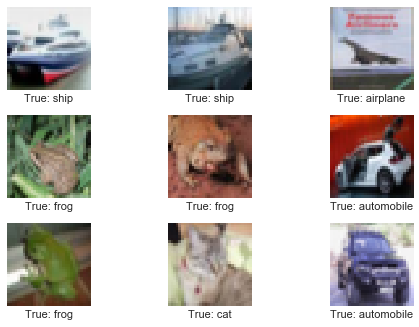

In [10]:
plot_images(images_test_for_print[1:10,:,:,:],cls_test_for_print[1:10], cls_pred=None, smooth=False)

In [12]:
images_train, cls_train, labels_train = load_training_data()
images_test, cls_test, labels_test = load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [13]:
# Check the data shape 
images_train.shape
images_test.shape
labels_train.shape   ##label_train and test_train is the one-hot coded label 
labels_test.shape

(50000, 32, 32, 3)

(10000, 32, 32, 3)

(50000, 10)

(10000, 10)

**Show the images after preprocessing**

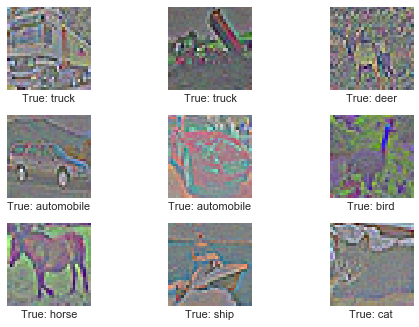

In [14]:
plot_images(images_train[1:10,:,:,:], cls_train[1:10], cls_pred=None, smooth=False)

## Step 3： Train the CNN Garph

In [42]:
# TRAIN
now = datetime.now()
dir_name = './CNN/log_{0}_{1}'.format(now.month,now.day)
export_dir = './CNN/savedmodel_{0}_{1}_{2}_{3}'.format(now.month,now.day,now.hour,now.minute)
img_size_cropped = 24

batch_size = 256
num_iterations = 80000
opt_method = 'adam'
print_unit = 2000
learning_rate = 1e-4

### Train the CNN model, please do not run this block after finishing training

In [52]:
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)
with tf.Graph().as_default():
    global_step = tf.train.get_or_create_global_step()

    with tf.device('/cpu:0'):
        x = tf.placeholder(tf.float32, shape=[None, 32, 32, num_channels], name='x')
        y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
        
        images = data_augmentation(images=x, training=True)

        with tf.name_scope('model'):
            logits, pool1_cnn, pool2_cnn = compute_logits_cnn(images)

        with tf.name_scope('loss'):
            loss = compute_cross_entropy(logits=logits, y=y_true)

        with tf.name_scope('accuracy'):
            prediction,accuracy = compute_accuracy(logits=logits, y=y_true)

        with tf.name_scope('opt'):
            opt = tf.train.AdamOptimizer(learning_rate)
            train_step = opt.minimize(loss)

        with tf.name_scope('summaries'):
            tf.summary.scalar('loss', loss)
            tf.summary.scalar('accuracy', accuracy)
            tf.summary.histogram('logit', logits)
            tf.summary.image('input', tf.reshape(images, [-1, img_size_cropped, img_size_cropped, num_channels]))
            summary_op = tf.summary.merge_all()

        saver = tf.train.Saver()

        sess2 = tf.Session()
        summary_writer = tf.summary.FileWriter(dir_name, sess2.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess2.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')

        try:
            print("Trying to restore last checkpoint ...")

            # Use TensorFlow to find the latest checkpoint - if any.
            last_chk_path = tf.train.latest_checkpoint(checkpoint_dir='./CNN/model/')
            pre_iteration = int(last_chk_path.split('.')[1].split('_')[-1])
            

            # Try and load the data in the checkpoint.
            saver.restore(sess2, save_path=last_chk_path)

            # If we get to this point, the checkpoint was successfully loaded.
            print("Restored checkpoint from:", last_chk_path)
        except:
            # If the above failed for some reason, simply
            # initialize all the variables for the TensorFlow graph.
            print("Failed to restore checkpoint. Initializing variables instead.")
            sess2.run(tf.global_variables_initializer())
            pre_iteration = 0

        for i in range(pre_iteration, pre_iteration + num_iterations):

            X_batch, y_batch = random_batch()

            _, summary = sess2.run((train_step, summary_op),
                                    feed_dict={x: X_batch, y_true: y_batch})

            if i%print_unit==0 or i == pre_iteration + num_iterations - 1 :
                summary_writer_train.add_summary(summary, i)

                (train_error, train_accuracy, train_logits) = sess2.run((loss, accuracy, logits), {x: X_batch, y_true: y_batch})
                print("\rStep {0:3d}: training accuracy {1:0.4f}".format(i, train_accuracy), flush=True)
                print("\rStep {0:3d}: training loss {1:0.4f}".format(i, train_error), flush=True)

                (test_error, test_accuracy, summary) = sess2.run((loss, accuracy,summary_op), {x:images_test, y_true:labels_test})
                print("\rStep {0:3d}: test accuracy {1:0.4f}".format(i, test_accuracy), flush=True)
                print("\rStep {0:3d}: test loss {1:0.4f}".format(i, test_error), flush=True)
                summary_writer_val.add_summary(summary, i)
                saver.save(sess2, './CNN/model/model_iter', global_step=i)
        
        save_name = "./CNN/model/final_model_" + str(i) + ".ckpt"
        save_path = saver.save(sess2, save_name)
        builder.add_meta_graph_and_variables(sess2, ["foo-tag"])

builder.save()

<tf.Tensor 'summaries/loss:0' shape=() dtype=string>

<tf.Tensor 'summaries/accuracy:0' shape=() dtype=string>

<tf.Tensor 'summaries/logit:0' shape=() dtype=string>

<tf.Tensor 'summaries/input:0' shape=() dtype=string>

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from ./CNN/model/final_model_79997.ckpt
Restored checkpoint from: ./CNN/model/final_model_79997.ckpt
Step 80000: training accuracy 0.8555
Step 80000: training loss 0.4546
Step 80000: test accuracy 0.7598
Step 80000: test loss 0.7206


'./CNN/model/model_iter-80000'

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./CNN/savedmodel_12_17_23_30\\saved_model.pb'


b'./CNN/savedmodel_12_17_23_30\\saved_model.pb'

### Load the trained CNN Model

In [53]:
with tf.Graph().as_default():
    global_step = tf.train.get_or_create_global_step()
    x = tf.placeholder(tf.float32, shape=[None, 32, 32, num_channels], name='x')
    y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
    images = data_augmentation(images=x, training=True)

    with tf.name_scope('model'):
        logits, pool1_cnn, pool2_cnn = compute_logits_cnn(images)

    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y_true)

    with tf.name_scope('accuracy'):
        prediction,accuracy = compute_accuracy(logits=logits, y=y_true)

    with tf.name_scope('opt'):
        opt = tf.train.AdamOptimizer(learning_rate)
        train_step = opt.minimize(loss)

    with tf.name_scope('summaries'):
        tf.summary.scalar('loss', loss)
        tf.summary.scalar('accuracy', accuracy)
        tf.summary.histogram('logit', logits)
        tf.summary.image('input', tf.reshape(images, [-1, img_size_cropped, img_size_cropped, num_channels]))
        summary_op = tf.summary.merge_all()
   
    saver = tf.train.Saver()
    sess2 = tf.Session()
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir='./CNN/model/')
    saver.restore(sess2, save_path=last_chk_path)
    
    X_batch, y_batch = random_batch()
    (train_error, train_accuracy, train_logits) = sess2.run((loss, accuracy, logits), {x: X_batch, y_true: y_batch})
    print("\r Training accuracy {0:0.4f}".format( train_accuracy), flush=True)
    print("\r Training loss {0:0.4f}".format( train_error), flush=True)
    
    (test_error, test_accuracy, summary) = sess2.run((loss, accuracy,summary_op), {x:images_test, y_true:labels_test})
    print("\r Test accuracy {0:0.4f}".format( test_accuracy), flush=True)
    print("\r Test loss {0:0.4f}".format( test_error), flush=True)
    

<tf.Tensor 'summaries/loss:0' shape=() dtype=string>

<tf.Tensor 'summaries/accuracy:0' shape=() dtype=string>

<tf.Tensor 'summaries/logit:0' shape=() dtype=string>

<tf.Tensor 'summaries/input:0' shape=() dtype=string>

INFO:tensorflow:Restoring parameters from ./CNN/model/final_model_80000.ckpt
 Training accuracy 0.7852
 Training loss 0.5069
 Test accuracy 0.7573
 Test loss 0.7293


## Step 4：Evaluate the CNN Graph

In [54]:
pool1_cnn, pool2_cnn 

(<tf.Tensor 'model/pool1:0' shape=(?, 12, 12, 64) dtype=float32>,
 <tf.Tensor 'model/pool1_1:0' shape=(?, 6, 6, 64) dtype=float32>)

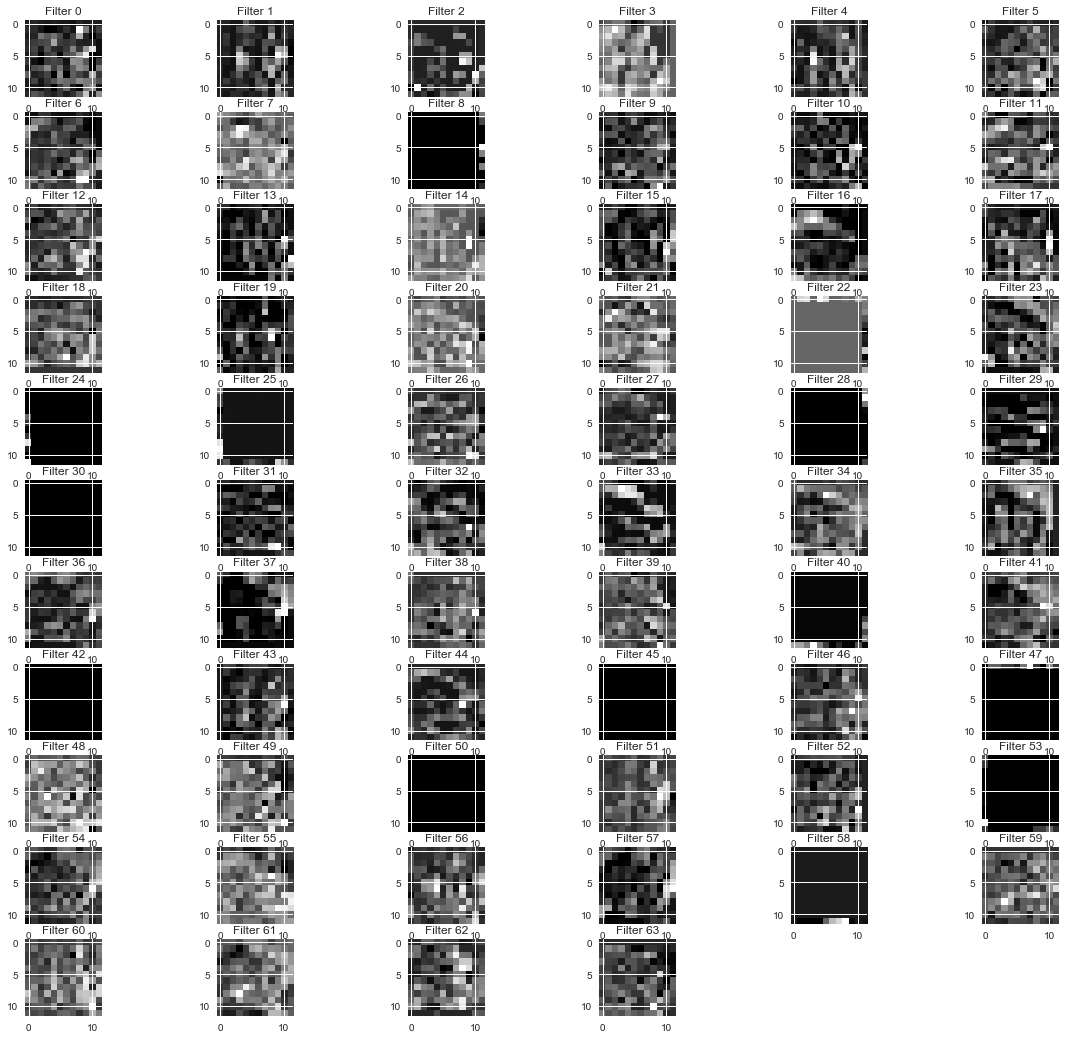

In [55]:
getActivations(sess2,pool1_cnn,images_test)

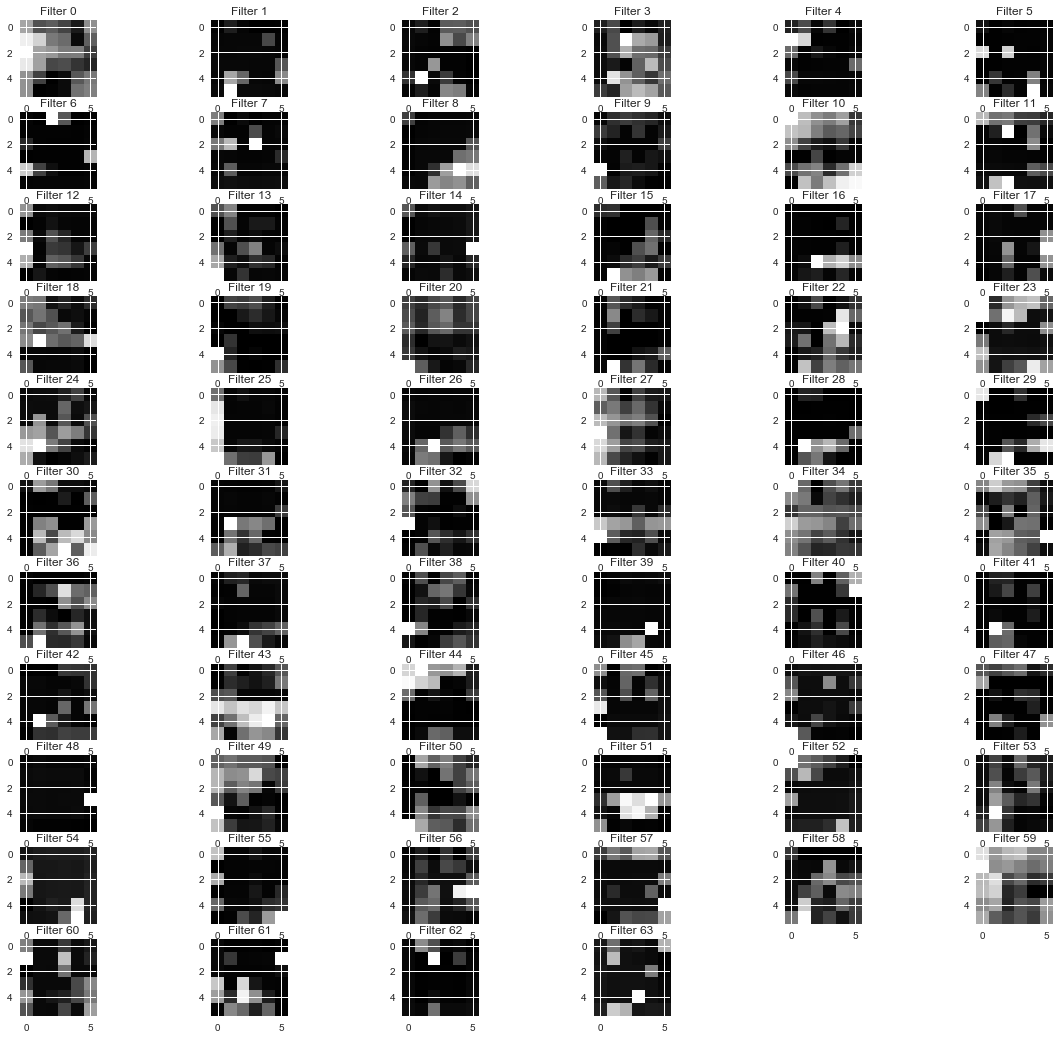

In [56]:
getActivations(sess2,pool2_cnn,images_test)

Confusion Matrix as numbers:
[739  28  46  17  15   8  16  11  78  42] (0) airplane
[ 21 863   4   5   7   6   6   4  32  52] (1) automobile
[ 59   4 693  53  49  40  56  30  11   5] (2) bird
[ 21  11  66 587  48 131  60  45  20  11] (3) cat
[ 14   4  44  41 736  28  40  69  13  11] (4) deer
[  9   8  58 152  39 643  19  58   6   8] (5) dog
[ 11   9  45  41  27   9 839   2  11   6] (6) frog
[  9   5  21  45  48  48  11 798   5  10] (7) horse
[ 52  21  19   8   4   3  11   7 838  37] (8) ship
[ 18 100   5  12   6   2   3  10  40 804] (9) truck
Plot Confusion Matrix:


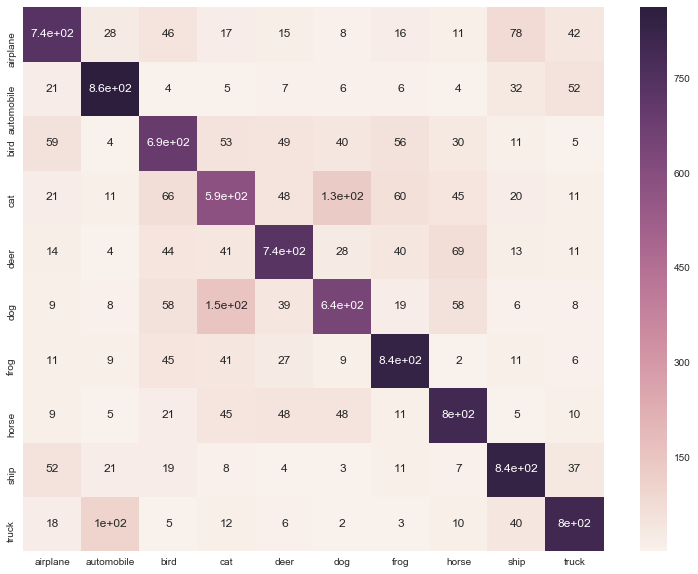

In [57]:
Test_Anlaysis(sess2,images_test, labels_test, cls_test)

## Step 5： Train the NIN Graph

In [35]:
now = datetime.now()

#dir_name = 'log_{0}_{1}'.format(now.month,now.day)
dir_name = './NIN/log_{0}_{1}'.format(now.month,now.day)
export_dir = './NIN/savedmodel_{0}_{1}_{2}_{3}'.format(now.month,now.day,now.hour,now.minute)

img_size_cropped = 24
batch_size = 256

num_iterations = 80000
print_unit = 2000
opt_method = 'adam'

### Train the NIN model, please do not run this block after finishing training

In [36]:
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)
tf.reset_default_graph()
with tf.Graph().as_default():
    
    global_step = tf.train.get_or_create_global_step()

    # Get images and labels for CIFAR-10.
    # Force input pipeline to CPU:0 to avoid operations sometimes ending up on
    # GPU and resulting in a slow down.
    
    with tf.device('/cpu:0'):
        # We build the model here as before
        x= tf.placeholder(tf.float32, shape=[None,32,32, num_channels], name='x')
        y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
        
        images = data_augmentation(images=x, training=True)
        
        with tf.name_scope('model'):
            logits,conv1,cccp1,cccp2,pool1,conv2,pool2,cccp3,cccp4,conv3,cccp5,cccp6,pool3 = compute_logits_NIN_with_BN(images)

            print('conv1:',conv1.shape,
                  'cccp1:',cccp1.shape,
                  'cccp2:',cccp2.shape,
                  'pool1:',pool1.shape,
                  'conv2:',conv2.shape,
                  'pool2:',pool2.shape,
                  'conv3:',conv3.shape,
                  'cccp5:',cccp5.shape)
            
        with tf.name_scope('loss'):
            loss = compute_cross_entropy(logits=logits, y=y_true)
        with tf.name_scope('accuracy'):
            prediction,accuracy = compute_accuracy(logits=logits, y=y_true)
            
        
        with tf.name_scope('opt'):   
            if opt_method == 'sgd':
                opt = tf.train.GradientDescentOptimizer(0.5)
            elif opt_method == 'rms':
                opt = tf.train.RMSPropOptimizer(.001)
            elif opt_method == 'adam':
                opt = tf.train.AdamOptimizer(1e-4)
            train_step = opt.minimize(loss)
                
        with tf.name_scope('summaries'):
            # create summary for loss and accuracy
            tf.summary.scalar('loss', loss) 
            tf.summary.scalar('accuracy', accuracy)
            # create summary for logits
            tf.summary.histogram('logits', logits)
            # create summary for input image
            tf.summary.image('input', tf.reshape(images, [-1,img_size_cropped,img_size_cropped, num_channels]))
            summary_op = tf.summary.merge_all()
    
        saver = tf.train.Saver()    ##Save the model
        
        sess = tf.Session()
    
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
    
        try:
            print("Trying to restore last checkpoint ...")

            # Use TensorFlow to find the latest checkpoint - if any.
            last_chk_path = tf.train.latest_checkpoint(checkpoint_dir='./NIN/model/')
            pre_iteration = int(last_chk_path.split('.')[1].split('_')[-1])
            

            # Try and load the data in the checkpoint.
            saver.restore(sess, save_path=last_chk_path)

            # If we get to this point, the checkpoint was successfully loaded.
            print("Restored checkpoint from:", last_chk_path)
            
        except:
            # If the above failed for some reason, simply
            # initialize all the variables for the TensorFlow graph.
            print("Failed to restore checkpoint. Initializing variables instead.")
            pre_iteration = 0
            sess.run(tf.global_variables_initializer())
    
        for i in range(pre_iteration, pre_iteration + num_iterations):
            X_batch, y_batch = random_batch()
            
            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y_true: y_batch})
            
                
                # write the summary output to file
            if i%print_unit==0 or i == pre_iteration + num_iterations - 1:
                
                summary_writer_train.add_summary(summary, i)                    
                (train_error,train_accuracy,train_logits) = sess.run((loss,accuracy,logits), {x: X_batch, y_true: y_batch})
                print("\rStep {0:3d}: training accuracy {1:0.4f}".format(i, train_accuracy), flush=True)
                print("\rStep {0:3d}: training loss {1:0.4f}".format(i, train_error), flush=True)
                
            if i%print_unit==0 or i == pre_iteration + num_iterations - 1:
                (test_error,test_accuracy, summary) = sess.run((loss,accuracy,summary_op), {x:images_test, y_true:labels_test})
                print("\rStep {0:3d}: test accuracy {1:0.4f}".format(i, test_accuracy), flush=True)
                print("\rStep {0:3d}: test error {1:0.4f}".format(i, test_error), flush=True)
                
                summary_writer_val.add_summary(summary, i)
                
                saver.save(sess, './NIN/model/model_iter', global_step=i)
                
        # Save the final model
        save_name = './NIN/model/final_model_' + str(i) + '.ckpt'
        save_path = saver.save(sess, save_name)
        builder.add_meta_graph_and_variables(sess,["foo-tag"])
builder.save()

conv1: (?, 24, 24, 96) cccp1: (?, 24, 24, 80) cccp2: (?, 24, 24, 48) pool1: (?, 12, 12, 48) conv2: (?, 12, 12, 96) pool2: (?, 6, 6, 96) conv3: (?, 6, 6, 96) cccp5: (?, 6, 6, 96)


<tf.Tensor 'summaries/loss:0' shape=() dtype=string>

<tf.Tensor 'summaries/accuracy:0' shape=() dtype=string>

<tf.Tensor 'summaries/logits:0' shape=() dtype=string>

<tf.Tensor 'summaries/input:0' shape=() dtype=string>

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from ./NIN/model/final_model_61999.ckpt
Restored checkpoint from: ./NIN/model/final_model_61999.ckpt
Step 62000: training accuracy 0.7461
Step 62000: training loss 0.7226
Step 62000: test accuracy 0.7284
Step 62000: test error 0.7845


'./NIN/model/model_iter-62000'

Step 64000: training accuracy 0.7227
Step 64000: training loss 0.8043
Step 64000: test accuracy 0.7329
Step 64000: test error 0.7812


'./NIN/model/model_iter-64000'

Step 66000: training accuracy 0.7578
Step 66000: training loss 0.6800
Step 66000: test accuracy 0.7334
Step 66000: test error 0.7687


'./NIN/model/model_iter-66000'

Step 68000: training accuracy 0.7812
Step 68000: training loss 0.6974
Step 68000: test accuracy 0.7322
Step 68000: test error 0.7694


'./NIN/model/model_iter-68000'

Step 70000: training accuracy 0.7148
Step 70000: training loss 0.7765
Step 70000: test accuracy 0.7372
Step 70000: test error 0.7696


'./NIN/model/model_iter-70000'

Step 72000: training accuracy 0.7656
Step 72000: training loss 0.6725
Step 72000: test accuracy 0.7437
Step 72000: test error 0.7541


'./NIN/model/model_iter-72000'

Step 74000: training accuracy 0.7812
Step 74000: training loss 0.5583
Step 74000: test accuracy 0.7394
Step 74000: test error 0.7547


'./NIN/model/model_iter-74000'

Step 76000: training accuracy 0.7617
Step 76000: training loss 0.6717
Step 76000: test accuracy 0.7431
Step 76000: test error 0.7549


'./NIN/model/model_iter-76000'

Step 78000: training accuracy 0.7969
Step 78000: training loss 0.6438
Step 78000: test accuracy 0.7416
Step 78000: test error 0.7459


'./NIN/model/model_iter-78000'

Step 80000: training accuracy 0.7539
Step 80000: training loss 0.7364
Step 80000: test accuracy 0.7426
Step 80000: test error 0.7423


'./NIN/model/model_iter-80000'

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./NIN/savedmodel_12_17_12_11\\saved_model.pb'


b'./NIN/savedmodel_12_17_12_11\\saved_model.pb'

### Load the trained NIN Model

In [37]:
tf.reset_default_graph()
with tf.Graph().as_default():
    global_step = tf.train.get_or_create_global_step()
    with tf.device('/cpu:0'):
        # We build the model here as before
        x= tf.placeholder(tf.float32, shape=[None,32,32, num_channels], name='x')
        y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
        images = data_augmentation(images=x, training=True)
        with tf.name_scope('model'):
            logits,conv1,cccp1,cccp2,pool1,conv2,pool2,cccp3,cccp4,conv3,cccp5,cccp6,pool3 = compute_logits_NIN_with_BN(images)
            
        with tf.name_scope('loss'):
            loss = compute_cross_entropy(logits=logits, y=y_true)
        with tf.name_scope('accuracy'):
            prediction,accuracy = compute_accuracy(logits=logits, y=y_true)
                
        with tf.name_scope('summaries'):
            # create summary for loss and accuracy
            tf.summary.scalar('loss', loss) 
            tf.summary.scalar('accuracy', accuracy)
            # create summary for logits
            tf.summary.histogram('logits', logits)
            # create summary for input image
            tf.summary.image('input', tf.reshape(images, [-1,img_size_cropped,img_size_cropped, num_channels]))
            summary_op = tf.summary.merge_all()
    
        saver = tf.train.Saver()    ##Save the model
        sess = tf.Session()
        last_chk_path = tf.train.latest_checkpoint(checkpoint_dir='./NIN/model/')
        saver.restore(sess, save_path=last_chk_path)

        
        X_batch, y_batch = random_batch()
        (train_error, train_accuracy, train_logits) = sess.run((loss, accuracy, logits), {x: X_batch, y_true: y_batch})
        print("\r Training accuracy {0:0.4f}".format( train_accuracy), flush=True)
        print("\r Training loss {0:0.4f}".format( train_error), flush=True)

        (test_error, test_accuracy, summary) = sess.run((loss, accuracy,summary_op), {x:images_test, y_true:labels_test})
        print("\r Test accuracy {0:0.4f}".format( test_accuracy), flush=True)
        print("\r Test loss {0:0.4f}".format( test_error), flush=True)

<tf.Tensor 'summaries/loss:0' shape=() dtype=string>

<tf.Tensor 'summaries/accuracy:0' shape=() dtype=string>

<tf.Tensor 'summaries/logits:0' shape=() dtype=string>

<tf.Tensor 'summaries/input:0' shape=() dtype=string>

INFO:tensorflow:Restoring parameters from ./NIN/model/final_model_80000.ckpt
 Training accuracy 0.7812
 Training loss 0.6100
 Test accuracy 0.7422
 Test loss 0.7544


## Step 6： Evaluate the NIN Graph

### 1. Show the shape of different layers

In [38]:
conv1,cccp1,cccp2,pool1,conv2,pool2,cccp3,cccp4,conv3,cccp5,cccp6,pool3

(<tf.Tensor 'model/conv1/conv1:0' shape=(?, 24, 24, 96) dtype=float32>,
 <tf.Tensor 'model/cccp1/cccp1:0' shape=(?, 24, 24, 80) dtype=float32>,
 <tf.Tensor 'model/cccp2/cccp2:0' shape=(?, 24, 24, 48) dtype=float32>,
 <tf.Tensor 'model/dropout/mul:0' shape=(?, 12, 12, 48) dtype=float32>,
 <tf.Tensor 'model/conv2/conv2:0' shape=(?, 12, 12, 96) dtype=float32>,
 <tf.Tensor 'model/dropout_1/mul:0' shape=(?, 6, 6, 96) dtype=float32>,
 <tf.Tensor 'model/cccp3/cccp3:0' shape=(?, 12, 12, 96) dtype=float32>,
 <tf.Tensor 'model/cccp4/cccp4:0' shape=(?, 12, 12, 96) dtype=float32>,
 <tf.Tensor 'model/conv3/conv3:0' shape=(?, 6, 6, 96) dtype=float32>,
 <tf.Tensor 'model/cccp5/cccp5:0' shape=(?, 6, 6, 96) dtype=float32>,
 <tf.Tensor 'model/cccp6/cccp6:0' shape=(?, 6, 6, 10) dtype=float32>,
 <tf.Tensor 'model/pool3:0' shape=(?, 1, 1, 10) dtype=float32>)

### 2. Visualize the Conv Layers

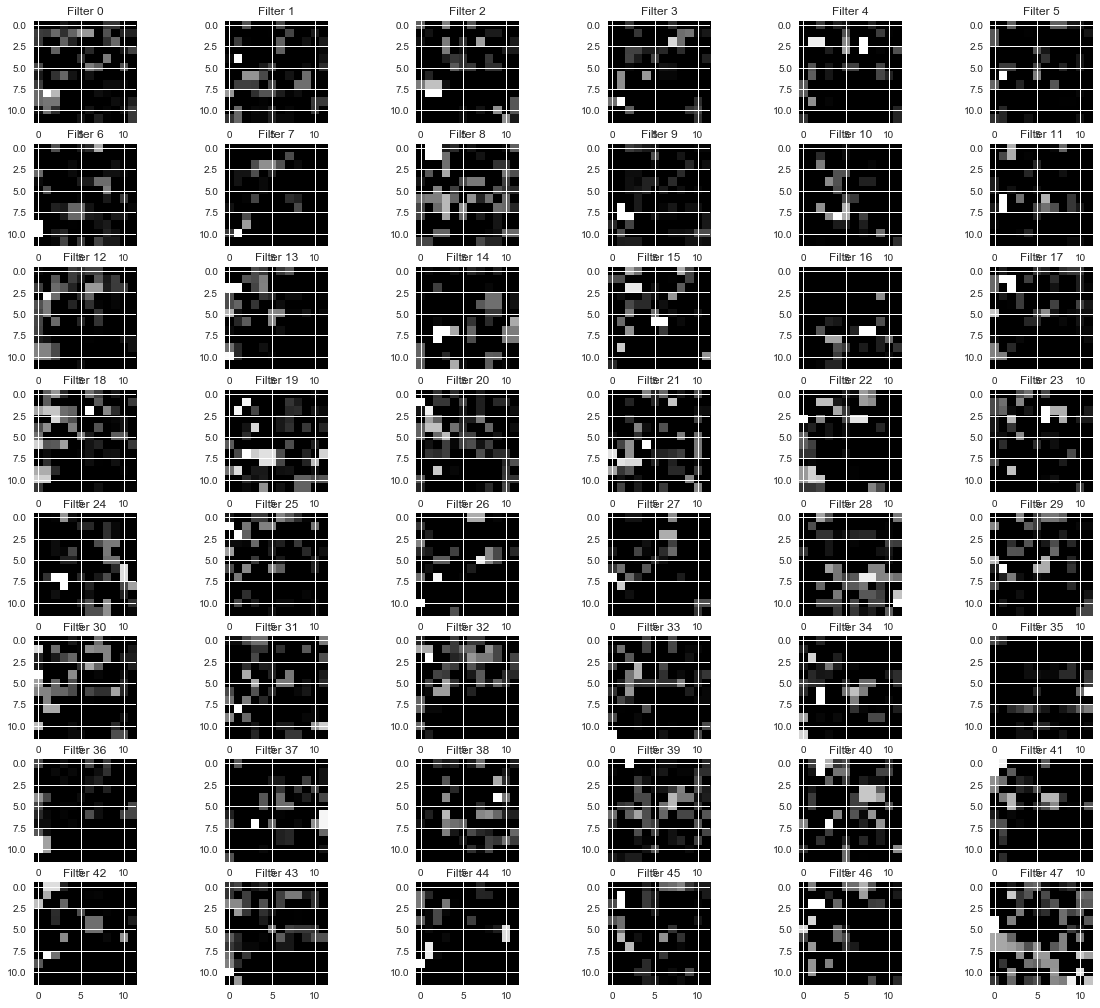

In [39]:
getActivations(sess,pool1,images_test)

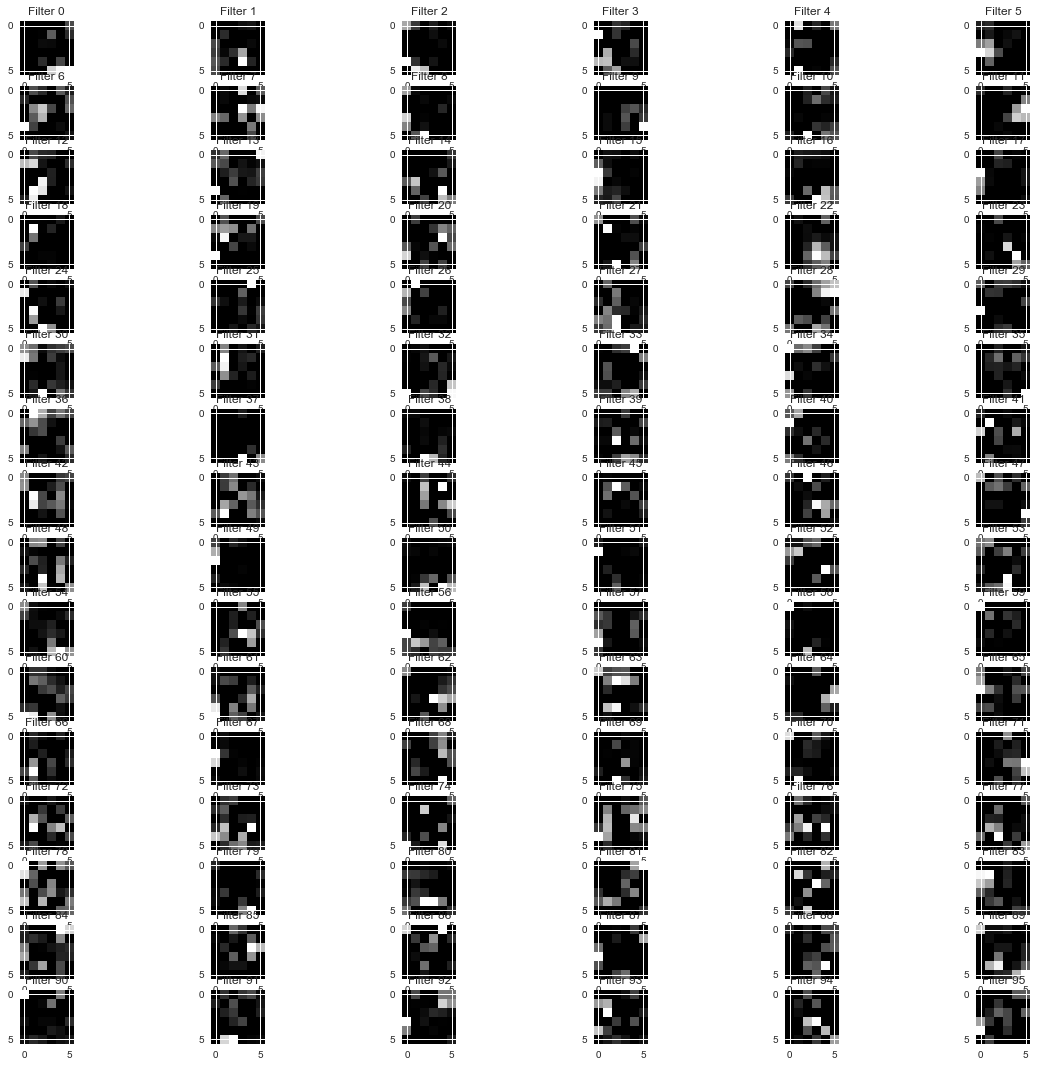

In [40]:
getActivations(sess,pool2,images_test)

### 3. Plot the confusion Matrix

Confusion Matrix as numbers:
[746  27  47  18  12   5  17  18  71  39] (0) airplane
[ 19 847   9   7   5   2   7   3  28  73] (1) automobile
[ 60   3 642  58  59  49  62  38  13  16] (2) bird
[ 33   7  64 546  56 163  58  37  18  18] (3) cat
[ 11   4  59  61 727  27  42  49  11   9] (4) deer
[ 14   6  48 138  51 650  24  58   2   9] (5) dog
[ 10   2  50  44  38  23 811   9  10   3] (6) frog
[ 16   5  25  34  65  47  11 776   3  18] (7) horse
[ 73  30  14  10   6   5   5   7 821  29] (8) ship
[ 25  55   9  16   5   3   9   8  36 834] (9) truck
Plot Confusion Matrix:


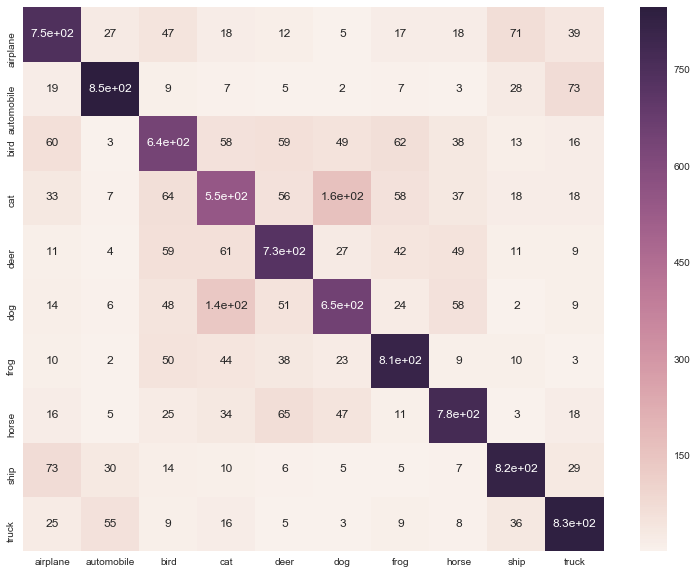

In [41]:
Test_Anlaysis(sess,images_test, labels_test, cls_test)